<a href="https://colab.research.google.com/github/Mors666/hopfieldRNN/blob/master/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
 # raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [3]:
tf.test.is_built_with_cuda()

True

In [0]:
import numpy as np  
from sympy import KroneckerDelta as kron
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
from multiprocessing import Process, Queue
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import  SimpleRNNCell

In [5]:
n = 20 #общее число работников в организации (кол-во вершин графа)
C = np.random.randint(0, 11, (n, n)) #затраты ребер графа (целые значения от 0 до 10)
#np.around(np.random.uniform(0, 1, (n,n)),decimals=2)  
C = np.tril(C) + np.tril(C, -1).T #матрица затрат должна быть симметричной
np.fill_diagonal(C, 0, wrap=False) 
print(C)

[[ 0  5  4  9 10  6  3  5  9  1  2  7  5  4  5 10  0  4  7  7]
 [ 5  0  0 10  4  6  7  8  3  6  8  4  5  9  0  7  5  4  6  5]
 [ 4  0  0  5  9  5  6  5  1  4 10  2  1  3  5  3  0  4  7  6]
 [ 9 10  5  0  8  5  3  0  2  3  6  3  8  4  9  2  8 10  9  1]
 [10  4  9  8  0  6  7  0  8  8  6  0  2  7  7  5  9  8  1  0]
 [ 6  6  5  5  6  0  8  9  4  7  7  7  6 10  5  3  4  1  5  5]
 [ 3  7  6  3  7  8  0  9  0  7  2  4  8  2  7  9  6  5  5  3]
 [ 5  8  5  0  0  9  9  0 10  9  3  6  9  3  5 10  6  4  3  0]
 [ 9  3  1  2  8  4  0 10  0 10 10  9  8  9  6  8  5 10  9  3]
 [ 1  6  4  3  8  7  7  9 10  0  2  8  2  9 10  1  6  3  3  8]
 [ 2  8 10  6  6  7  2  3 10  2  0  1  1  1  9  8  5  8  2  3]
 [ 7  4  2  3  0  7  4  6  9  8  1  0  1 10  5  8  0  5  4  0]
 [ 5  5  1  8  2  6  8  9  8  2  1  1  0  1  9  2 10  2  6  7]
 [ 4  9  3  4  7 10  2  3  9  9  1 10  1  0  5  1  9  7  8 10]
 [ 5  0  5  9  7  5  7  5  6 10  9  5  9  5  0  3 10  9  0  8]
 [10  7  3  2  5  3  9 10  8  1  8  8  2  1  3  0  3  0

In [6]:
P = np.random.randint(0, 2, (n, n)) #несуществующие ребра графа
P = np.tril(P) + np.tril(P, -1).T
#P = (P + P.T)/2
np.fill_diagonal(P, 1, wrap=False)
print('матрица несуществующих ребер')
print(P)

матрица несуществующих ребер
[[1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1]
 [0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0]
 [0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0]
 [1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0]
 [0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1]
 [0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1]
 [1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0]
 [1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1]
 [0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0]
 [0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1]
 [1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0]
 [1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1]
 [1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0]
 [1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0]
 [1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1]
 [1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0]
 [1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1]]


In [7]:
for i in range(n):
    for j in range(n):
        if P[i][j] == 1:
            C[i][j] = 10
print('матрица затрат')
print(C)

матрица затрат
[[10 10  4  9 10  6  3 10 10  1  2 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  4  6 10  8 10 10 10  4  5 10  0 10 10 10  6 10]
 [ 4 10 10  5 10  5  6 10 10 10 10  2  1 10 10 10 10 10 10  6]
 [ 9 10  5 10  8 10 10 10 10 10 10 10  8 10 10 10  8 10 10  1]
 [10  4 10  8 10 10  7  0 10 10  6  0 10 10  7 10  9 10  1  0]
 [ 6  6  5 10 10 10 10 10  4  7  7  7 10 10  5  3 10  1  5 10]
 [ 3 10  6 10  7 10 10  9 10  7 10 10 10 10 10 10  6  5  5 10]
 [10  8 10 10  0 10  9 10 10 10  3  6 10  3 10 10  6  4  3  0]
 [10 10 10 10 10  4 10 10 10 10 10  9 10  9  6  8 10 10 10 10]
 [ 1 10 10 10 10  7  7 10 10 10  2  8  2 10 10 10  6  3  3  8]
 [ 2 10 10 10  6  7 10  3 10  2 10 10 10 10 10 10  5  8  2 10]
 [10  4  2 10  0  7 10  6  9  8 10 10 10 10  5 10  0  5  4  0]
 [10  5  1  8 10 10 10 10 10  2 10 10 10 10 10  2 10  2  6 10]
 [10 10 10 10 10 10 10  3  9 10 10 10 10 10 10 10 10  7 10 10]
 [10  0 10 10  7  5 10 10  6 10 10  5 10 10 10 10 10 10 10 10]
 [10 10 10 10 10  3 10 10  8 10 10 10  2

In [8]:
#константы:
mu1 =950#3000
mu2 = 475#480
mu3 = 1500#50000
mu4 = 2500#15000
mu5 = 2500#50000
A = 0.0001
B = 0.00001
D = 0.00001
ex_number = np.around(n*2/3, decimals=0) # 2/3 - кол-во исполнителей относительно общего числа рработников
director = 0 #номер узла, соответствующего топ-менеджеру в иерархии
executors = random.sample(range(1,n), int(ex_number)) #случайно выбранные индексы исполнителей  
print(executors)

[14, 13, 15, 5, 8, 18, 4, 1, 3, 6, 2, 17, 16]


In [0]:
weights = np.zeros((n*n,n*n)) 

In [0]:
def init_weights():
    start = time.time()
      
    for x in range(n):
        for i in range(n):
            for y in range(n):
                for j in range(n):
                 
                    weights[x*n+i,y*n+j] = mu2*kron(x, y)*kron(i, j) - mu4*kron(x, y) - mu4*kron(i, j) + mu4*kron(j, x) + mu4*kron(i, y)
    
    finish = time.time()
    result = finish - start
    print("Время на инициализацию матрицы весов: " + str(result) + " секунд")
    return weights

In [11]:
weights = init_weights()
print(weights)

Время на инициализацию матрицы весов: 2.323946237564087 секунд
[[  475.     0.     0. ...     0.     0.     0.]
 [    0. -4525. -2500. ...     0.     0.     0.]
 [    0. -2500. -4525. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... -4525. -2500.     0.]
 [    0.     0.     0. ... -2500. -4525.     0.]
 [    0.     0.     0. ...     0.     0.   475.]]


In [0]:
def weights_init(shape, dtype='float32'): #инициализатор весов нейронов               
    return K.variable(value=weights, dtype=dtype)

In [0]:
def energy(m,OUT, ftype,out_from_others = []):
    OUT = K.reshape(OUT, (n,n))
    #ftype = ftype + OUT
     
    E1 = 0 
    E2 = 0
    E3 = 0
    E4 = 0
    E5 = 0
    for x in range(n):
        for i in range(n):
            if (i != x) and (x!=m and i!=director):
                E1 = E1 + C[x][i]*(1/(1+ftype[x][i]))*OUT[x][i]  
                E3 = E3+P[x][i]*OUT[x][i]
            if i != x:
                E2 = E2 + OUT[x][i]*(1-OUT[x][i])
                 
                
    out1=0
    out2=0
    #square=0
    for x in range(n):
        for i in range(n):
            if i != x:
                out1 = out1+OUT[x][i]
                out2 = out2+OUT[i][x]
        #square = (out1-out2)*(out1-out2)
        E4 = E4 + (out1-out2)*(out1-out2)
        
    E5 = 1-OUT[m][director]
    
    E = mu1*E1 + mu2*E2 + mu3*E3 + mu4*E4 + mu5*E5
    
    OUT = K.reshape(OUT, (n*n,1))
    return E

In [0]:
def bias_init(shape, dtype='float32'): #инициализатор смещения нейронов (bias)
        bias = np.zeros((n,n))
        for x in range (n):
            for i in range (n):
                if (x==m and i==director):
                    bias[x][i] = mu5/2-mu2/2
                else:
                    bias[x][i] = -mu1/2*C[x][i]*ftype[x][i]-mu3/2*P[x][i]-mu2/2 
     
        bias=np.concatenate(bias)
        b = np.zeros((n*n,1))
 
        for x in range (n*n):
            b[x][0]= bias[x]
        #b = b.shape((n*n,1))
        return K.variable(value=b, dtype=dtype)

In [0]:
def input_tensor():  
        IN = np.full((n,n), 0.5 + np.random.uniform(-0.00001, 0.00001, (n,n)))  # 0.00001 
        IN.shape = (n*n,1)
        return K.variable(value=IN, dtype='float32')

In [0]:
class RNN(SimpleRNNCell): #сеть Хопфилда для конкретного исполнителя
    def __init__(self,**kwargs):
        super(RNN, self).__init__(**kwargs)
        #self.weights = weights
        self.prev_in = [] #входные значения с предыдущих итераций
        self.energies = [] #значения функции энергии
        self.prev_energy = np.Infinity #значение энергии на предыдущей итерации
        self.worker = -1 #номер узла исполнителя, для которого используется сеть
        self.stop = False #для остановки в случае увеличения энергии
        self.result = input_tensor() #выходной сигнал после определенной итерации
        
    def build(self,input_shape):
        self.kernel = weights_init((n*n,n*n)) #self.add_weight(shape=(input_shape[-1], self.units),
                        #              name='kernel',
                         #             initializer=self.kernel_initializer  )
          
        self.bias =  bias_init((n,n))
        
        self.built = True
        #super(RNN, self).build(input_shape)
        
    def threshold(self, out, threshold_value=0.5): #пороговая функция сети
        return K.cast(K.greater(K.clip(out, 0, 1), threshold_value), dtype='float32')
     
     
    def call(self,inputs,states=[], training=None ): #функция, совершающая 1 итерацию сети
        inputs = K.reshape(inputs, (1,n*n))
         
        output = K.dot(  K.reshape( inputs,(1,n*n)),self.kernel) 
        #output = output + self.bias
        
        output = K.bias_add(output,  K.reshape(self.bias,(n*n,)))
        output = self.activation(output)
        inputs = output
          
        if len(self.prev_in) ==1:
            inputs = self.prev_in[0] + D*output
             
        elif len(self.prev_in) ==2:
            inputs =  self.prev_in[1] - A*self.prev_in[0] + D*output
            
        elif len(self.prev_in) > 2:
            inputs = self.prev_in[len(self.prev_in)-1] - A*self.prev_in[len(self.prev_in)-2] - B*self.prev_in[len(self.prev_in)-3]+ D*output
             
        self.prev_in.append(inputs)
        
        return  inputs 

In [0]:
def create_RNN(m):
    mRNN = RNN(                         #создание экземпляра нейронной сети для конкретного исполнителя
               units=n,
               activation='sigmoid',
               use_bias=True,
               kernel_initializer=weights_init,
               recurrent_initializer=weights_init,
               bias_initializer=bias_init,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,)

    mRNN.build((n*n,)) #формирование сети
    #all_RNN.append(mRNN)
    mRNN.worker = m
    return mRNN

In [0]:
def one_iteration(i,q): #
    all_RNN[i].bias = bias_init(shape = (n,n)) 
    all_RNN[i].prev_in.append( all_RNN[i].call(inputs=all_RNN[i].result)) #
    #mOUT = all_RNN[i].threshold(all_RNN[i].call(inputs=all_RNN[i].result))
    #global ftype 
    
    if (K.eval(all_RNN[i].prev_energy) - K.eval(energy(all_RNN[i].worker,all_RNN[i].call(inputs=all_RNN[i].result),ftype)))<1e-5:
                                                       #all_RNN[i].prev_in[len(all_RNN[i].prev_in)-1],ftype)):
        
        ''' print('stop')
        print(K.eval(all_RNN[i].prev_energy))
        print(K.eval(energy(all_RNN[i].worker,mOUT,ftype)))'''
        all_RNN[i].stop = True
        all_RNN[i].result = all_RNN[i].threshold(all_RNN[i].prev_in[len(all_RNN[i].prev_in)-2])
         
    else:
        all_RNN[i].prev_energy =  energy(all_RNN[i].worker,all_RNN[i].call(inputs=all_RNN[i].result),ftype)
                                         #all_RNN[i].prev_in[len(all_RNN[i].prev_in)-1], ftype) #(iter < 10) or
        all_RNN[i].energies.append(all_RNN[i].prev_energy)
         
        all_RNN[i].result = all_RNN[i].call(inputs=all_RNN[i].result)#all_RNN[i].prev_in[len(all_RNN[i].prev_in)-1]
         
    q.put([all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop,all_RNN[i].prev_in,all_RNN[i].energies])

In [19]:
ftype = np.zeros((n,n))
m=0
print(bias_init(shape = (n,n)))

<tf.Variable 'Variable:0' shape=(400, 1) dtype=float32, numpy=
array([[1012.5],
       [-987.5],
       [-237.5],
       [-237.5],
       [-987.5],
       [-237.5],
       [-237.5],
       [-987.5],
       [-987.5],
       [-237.5],
       [-237.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-237.5],
       [-237.5],
       [-987.5],
       [-237.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-237.5],
       [-237.5],
       [-987.5],
       [-237.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-237.5],
       [-987.5],
       [-237.5],
       [-987.5],
       [-987.5],
       [-237.5],
       [-987.5],
       [-237.5],
       [-237.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-987.5],
       [-237.5],
       [-237.5],
       [-987.5],
       [-987.5],
  

In [0]:
all_start = time.time()

In [21]:
 if __name__ == '__main__':
    ftype = np.zeros((n,n)) #Матрица ftype нейронов
    all_RNN=[]
    for m in executors:
        all_RNN.append(create_RNN(m))
    iterat = 0
     
    #while (K.eval(mRNN.prev_energy) >= K.eval(energy(mRNN.worker,mRNN.result,ftype))for mRNN in all_RNN):
    while not all(mRNN.stop == True for mRNN in all_RNN) and iterat<10:
        print(iterat)
        if iterat>0:
            for i in range(len(executors)):
                ftype = ftype + K.eval(all_RNN[i].result).reshape(n,n)
        iterat = iterat + 1
        #param = np.Infinity
        queues = []
        #queue = Queue()
        procs = []
        for i in range(len(executors)):
            if (all_RNN[i].stop == False):
                queue = Queue()
                queues.append(queue)
                p = Process(target=one_iteration, args=(i,queue,))
                procs.append(p)     
                p.start()
             
           
                #[all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop] = queue.get()
                #all_RNN[i].energies.append(all_RNN[i].prev_energy)
            
        for proc in procs:
            proc.join()
        
        j=0
        for i in range(len(executors)):
            if (all_RNN[i].stop == False) :
                 
                [all_RNN[i].result,all_RNN[i].prev_energy,all_RNN[i].stop,all_RNN[i].prev_in,all_RNN[i].energies] = queues[j].get()
                j = j+1
            
            #ftype = ftype + K.eval(all_RNN[i].result).reshape(n,n)
            #print(ftype)
            
        ftype = np.zeros((n,n))

0
1
2
3
4


In [22]:
for i in range(len(executors)):
    OUT = K.eval(all_RNN[i].threshold(all_RNN[i].result))
    OUT.shape = (n,n)
    print("Результаты для исполнителя "+str(executors[i])+":") 
    print(OUT)

Результаты для исполнителя 14:
[[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1

energy values
453732.6875
123026.078125
122962.0859375


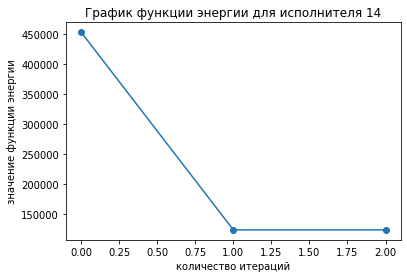

energy values
631018.8125
303274.625
302884.71875
302502.25


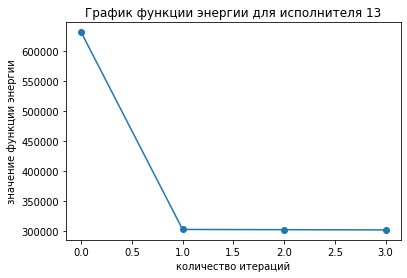

energy values
451808.34375
115348.0859375
115272.734375


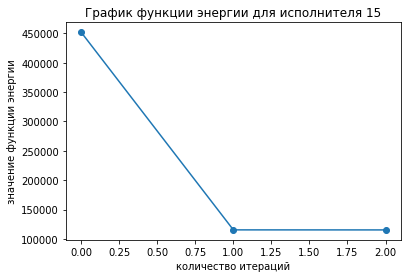

energy values
418549.8125
99313.8046875
99277.625
99174.875


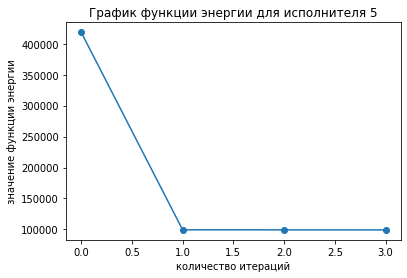

energy values
511465.3125
190843.4375
190672.59375
190543.71875


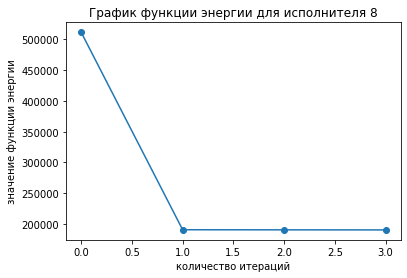

energy values
467451.90625
143294.515625
143183.296875


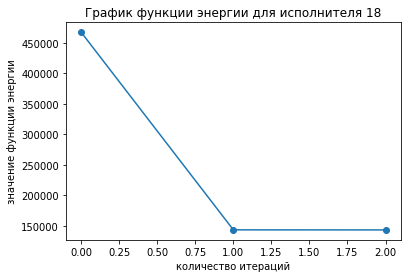

energy values
443627.3125
118564.609375
118516.421875
118439.3125


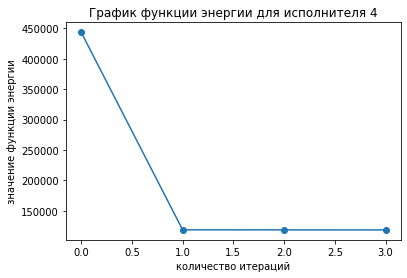

energy values
462463.625
131279.375
131205.75


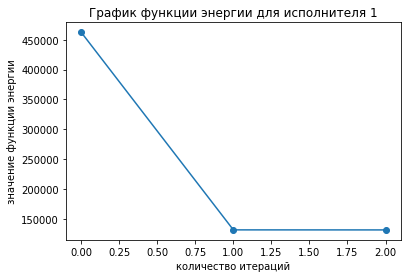

energy values
415417.40625
88138.546875


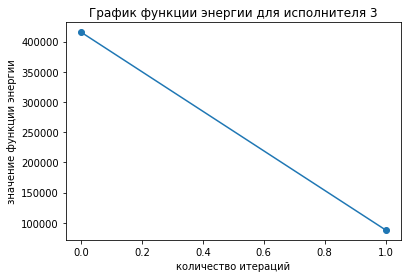

energy values
495845.0
170324.59375
170163.09375


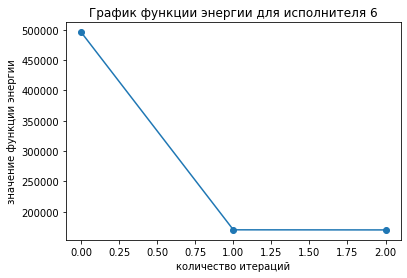

energy values
491322.0
159082.796875
158973.859375
158924.3125


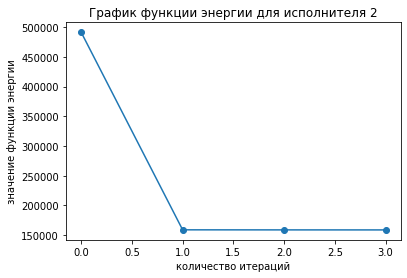

energy values
472103.0625
149605.125
149482.703125
149417.046875


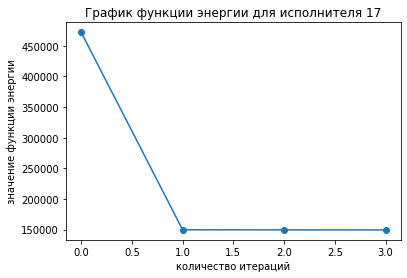

energy values
488600.0
163990.390625
163848.0


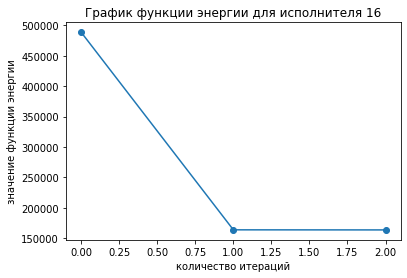

In [23]:
for mRNN in  all_RNN:
    iterations = np.arange(0,len(mRNN.energies))
#print(iterations)
#print(len(energies))
    e =  np.zeros((len(mRNN.energies),))
#print(e)
    print("energy values")
    for i in range(len(mRNN.energies)):
        e[i] = K.eval(mRNN.energies[i])
         
        print(e[i])
    #print(K.eval(energies[i]))
#j=0
#for i in range(0,len(mRNN.energies),10):
    #energy[j] = K.eval(mRNN.energies[i])
    #j=j+1
        
    plt.plot(iterations,e, marker='o')
    plt.title("График функции энергии для исполнителя "+str(mRNN.worker))
    plt.xlabel("количество итераций")
    plt.ylabel("значение функции энергии")
    plt.show()

In [24]:
all_finish = time.time()
all_result = all_finish - all_start
print("Общее время: " + str(all_result) + " секунд")

Общее время: 41.29737710952759 секунд
